In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.esn import ESN
from adjoint_esn.rijke_esn import RijkeESN
from adjoint_esn.utils import preprocessing as pp
from adjoint_esn.utils.enums import eParam, get_eVar
from pathlib import Path
from adjoint_esn.rijke_galerkin.solver import Rijke
from scipy.integrate import odeint
from adjoint_esn.utils import signals as sig
import adjoint_esn.utils.visualizations as vis
from adjoint_esn.utils import errors,scalers
from scipy import signal
from functools import partial
from src.configs.config import get_config
import yaml

## Data generation

In [2]:
# number of galerkin modes
N_g = 4

# simulation options
sim_time = 800
sim_dt = 1e-3

# directory to search for simulation data, if the data doesn't exist, 
# then it will simulate the system
data_dir=Path('data_new')

# which regimes to use for training and validation
INIT_beta_list = [1.0,2.0,3.0,4.0,5.0]
INIT_tau_list = [0.1,0.15,0.2,0.25,0.3]
INIT_p_list = pp.make_param_mesh([INIT_beta_list,INIT_tau_list])

train_idx_list=np.arange(len(INIT_p_list))
val_idx_list=np.arange(len(INIT_p_list))

transient_time = 200

# network time step
network_dt = 1e-2

washout_time = 4

# which states to use as input and output
# for standard ESN these should be the same, e.g. both 'eta_mu'
# for Rijke ESN, input and output should be 'eta_mu_v_tau' and 'eta_mu' respectively
input_vars='eta_mu_v_tau'
eInputVar = get_eVar(input_vars,N_g)
output_vars='eta_mu'
eOutputVar = get_eVar(output_vars,N_g)

# which system parameter is passed to the ESN
param_vars=['beta']

# if using Rijke ESN what is the order of u_f(t-tau) in the inputs,
# [u_f(t-tau), u_f(t-tau)^2 ..., u_f(t-tau)^(u_f_order)]
u_f_order = 1


# length of training time series
train_time = 200
# length of validation time series
validation_time = 200
# can add test, then add it in the loop_names and loop_times
test_time = 10

loop_names=['train','val']
loop_times = [train_time,validation_time]

DATA = {}
for loop_name in loop_names:
    DATA[loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'t':[]}

for p_idx, p in enumerate(INIT_p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    regime_data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        loop_names=loop_names,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)
    
    for loop_name in loop_names:
        [DATA[loop_name][var].append(regime_data[loop_name][var]) for var in DATA[loop_name].keys()]

# dimension of the inputs
dim = DATA["train"]["u"][0].shape[1]

# how to scale the inputs (applied apart from the input_scaling)
scale = [None]*2
scale[0] = np.zeros(dim)
scale[1] = np.ones(dim)

### Plot data

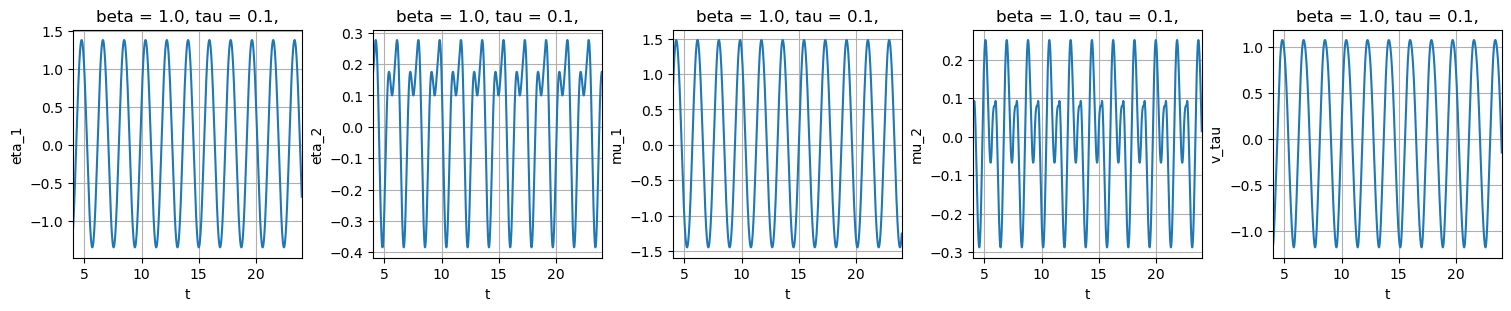

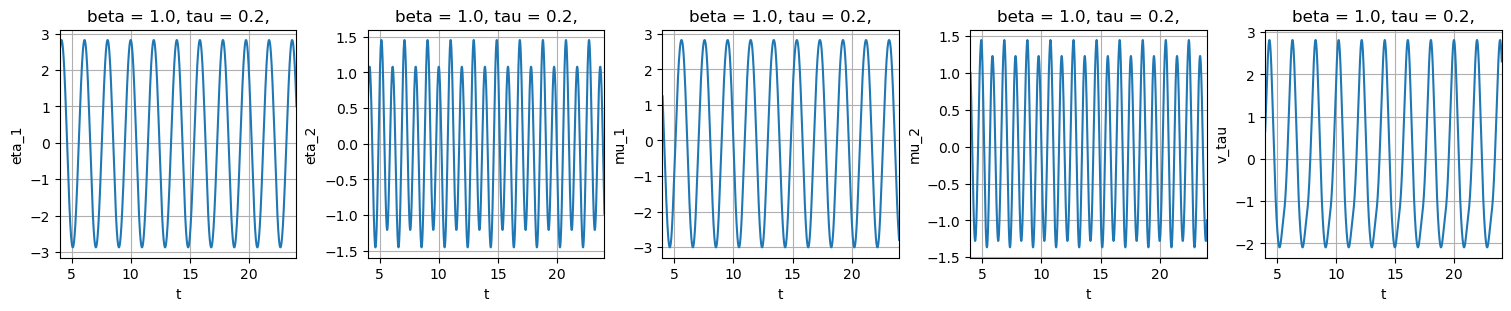

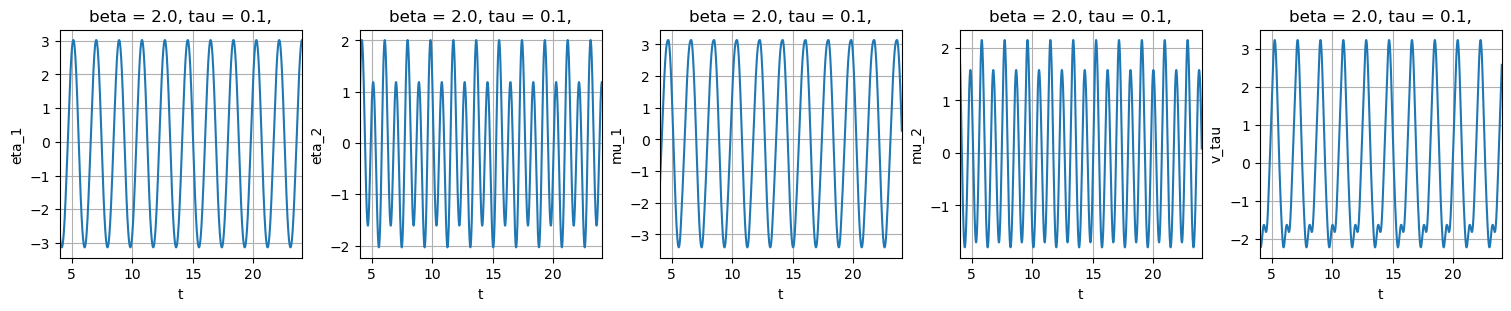

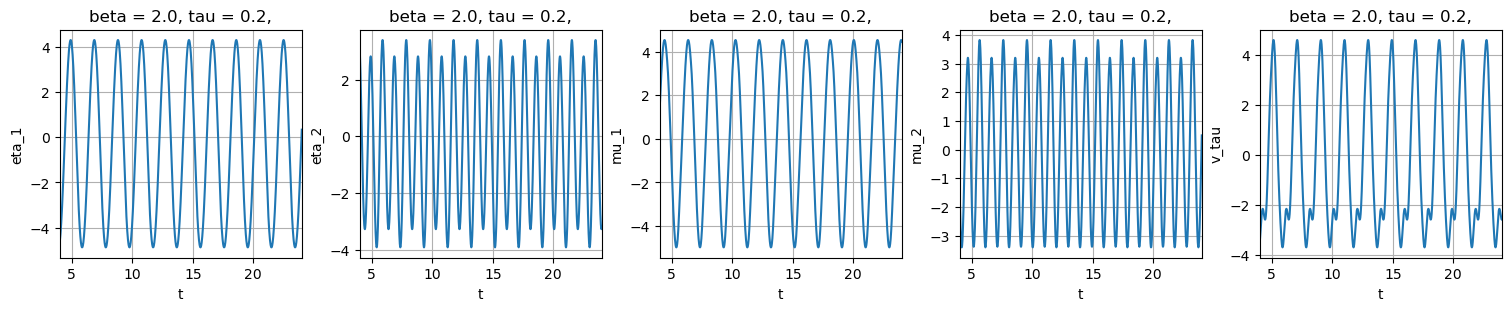

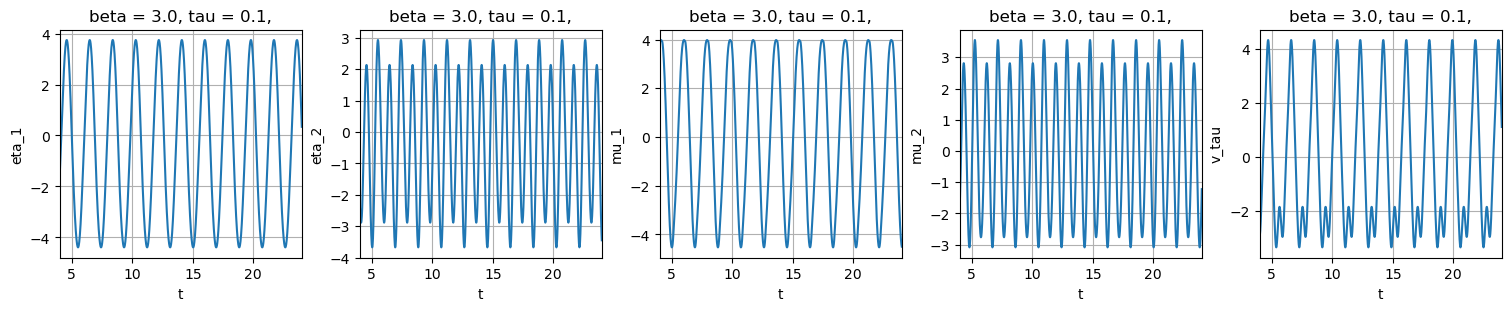

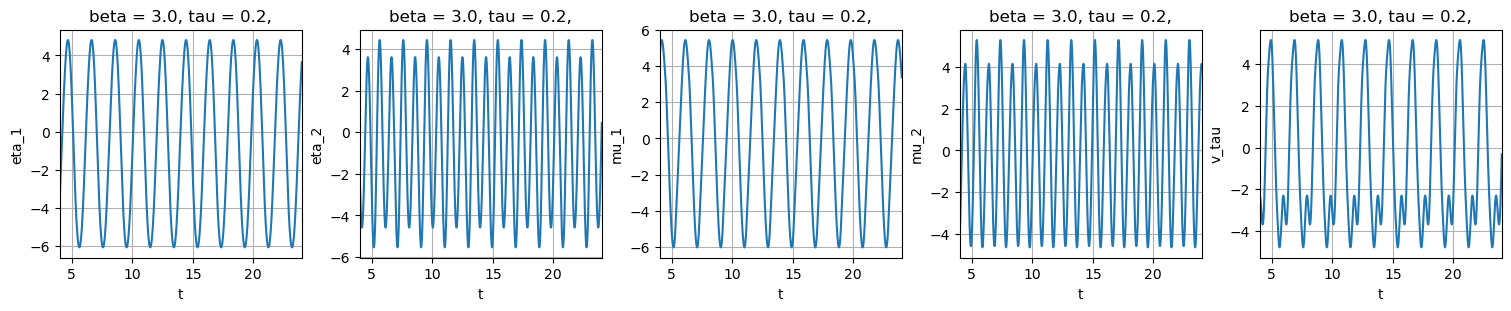

In [3]:
len_p_list=len(INIT_p_list)
plt_idx = [eInputVar.eta_1,eInputVar.eta_2,eInputVar.mu_1,eInputVar.mu_2,eInputVar.v_tau]
for p_idx in range(len_p_list):
    plt.figure(figsize = (15,3),constrained_layout=True)
    for j, k in enumerate(plt_idx):
        plt.subplot(1,len(plt_idx),j+1)
        vis.plot_lines(DATA["train"]["t"][p_idx],DATA["train"]["u"][p_idx][:,k],
                   title=f"beta = {INIT_p_list[p_idx][eParam.beta]}, tau = {INIT_p_list[p_idx][eParam.tau]},",
                   xlabel='t',
                   ylabel=k.name)
        plt.xlim([4,24])

## Run hyperparameter search

In [4]:
from adjoint_esn.validation_v2 import validate as validate_v2

# range for hyperparameters 
spec_in     = np.log10(0.001) 
spec_end    = np.log10(1.0)
in_scal_in  = 0.05
in_scal_end = 0.15
u_f_scal_in  = 1.0
u_f_scal_end = 2.0
leak_in     = 0.1    
leak_end    = 0.4
param_var_in = 1.0 
param_var_end = 2.0
param_mean_in = -3.0
param_mean_end = -1.0
grid_range = [[in_scal_in, in_scal_end],[u_f_scal_in, u_f_scal_end],[param_mean_in, param_mean_end],[param_var_in, param_var_end]]

# hyperparameter names, should match the attributes of ESN
hyp_param_names = ['input_scaling','u_f_scaling','parameter_normalization_mean','parameter_normalization_var']
# scales, uniform or log10
hyp_param_scales = ['uniform','uniform','uniform','uniform']
N_washout = 100
N_val = 800
N_transient = 0
reservoir_size = 1200
connectivity = 3
ESN_dict = {'reservoir_size': reservoir_size, 
            #'dimension' : dim, 
            'N_g' : N_g,
            'x_f' : 0.2,
            'tau' : 0.2,
            'dt' : 0.01,
            'u_f_order': u_f_order,
            'parameter_dimension' : len(param_vars),
            'reservoir_connectivity' : connectivity,
            'input_normalization': scale, 
            'input_bias' : np.array([]),
            'output_bias' : np.array([]),
            'parameter_normalization': [np.array([0.0]),np.array([1.0])],
            'r2_mode': False,
            'input_weights_mode': "sparse_grouped_rijke_dense",
            'input_only_mode': True,
            }
min_dict = validate_v2(grid_range,hyp_param_names,hyp_param_scales,
    n_calls = 10, n_initial_points = 5, n_ensemble = 1,
    ESN_dict = ESN_dict, ESN_type = "rijke", tikh = 1e-3, 
    U_washout_train = DATA["train"]["u_washout"],
    U_train = DATA["train"]["u"],
    U_val = DATA["val"]["u"],
    Y_train = DATA["train"]["y"],
    Y_val = DATA["val"]["y"],
    P_washout_train = DATA["train"]["p_washout"],
    P_train = DATA["train"]["p"],
    P_val = DATA["val"]["p"],
    n_folds = 4,
    n_realisations=1,
    N_washout_steps = N_washout,
    N_val_steps = N_val,
    N_transient_steps = N_transient,
    train_idx_list=train_idx_list,
    val_idx_list=val_idx_list,
    p_list=INIT_p_list)

Running 1/1 of ensemble.
--NEW RUN-- 1
input_scaling 0.10928446182250184
u_f_scaling 1.8442657485810177
parameter_normalization_mean -1.284108764754486
parameter_normalization_var 1.8472517387841256


Realisation: 0
Val regime: 0
Val regime error: 0.15436992624709445
Val regime: 1
Val regime error: 0.07927433979498946
Val regime: 2
Val regime error: 0.09139658960932015
Val regime: 3
Val regime error: 0.141763734265934
Val regime: 4
Val regime error: 0.21369820058936462
Val regime: 5
Val regime error: 0.14269867596040714
Realisation error: 0.8232014664671099


Run 1 error: 0.8232014664671099


--NEW RUN-- 2
input_scaling 0.11235636967859725
u_f_scaling 1.3843817072926998
parameter_normalization_mean -2.404930786911055
parameter_normalization_var 1.0567129773174433


Realisation: 0
Val regime: 0
Val regime error: 0.1432356675245337
Val regime: 1
Val regime error: 0.07439846207256118
Val regime: 2
Val regime error: 0.10176307275435328
Val regime: 3
Val regime error: 0.13083199336238016
Va

## Train ESN

In [27]:
print('System dimension: ', dim)
my_ESN = ESN(reservoir_size = 1200, 
            dimension = dim, 
            parameter_dimension = 1, 
            reservoir_connectivity = 20, 
            spectral_radius = 0.91465898,                            
            input_scaling = 0.9496385,
            leak_factor = 0.30048716,
            parameter_normalization=[np.array([7.75984604,]),np.array([3.22040487])],
            output_bias = np.array([]),
            input_normalization = scale, 
            r2_mode=True,
            input_seeds=[11,22,3],
            reservoir_seeds=[4,5])

System dimension:  9
Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


In [3]:
print('System dimension: ', dim)
my_ESN = RijkeESN(reservoir_size = 1200, 
            N_g = N_g,
            u_f_order = u_f_order,
            x_f = 0.2,
            tau = 0.2,
            dt = 0.01,
            parameter_dimension = 1, 
            reservoir_connectivity = 3, 
            spectral_radius = 0.1,    
            input_scaling = 0.1130046,                             
            u_f_scaling= 1.39332475,
            leak_factor = 0.20882743,
            parameter_normalization=[np.array([-2.12880738,]),np.array([1.38678768])],
            input_bias = np.array([]),
            output_bias = np.array([]),
            input_normalization = scale, 
            r2_mode=False,
            input_seeds=[1,2,3],
            reservoir_seeds=[4,5],
            input_weights_mode="sparse_grouped_rijke_dense",
            input_only_mode=True,)

System dimension:  9
Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Input weights of u_f(t-tau) are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


In [4]:
my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"],
             tikhonov = 1e-3, 
             P_washout=DATA["train"]["p_washout"], 
             P_train=DATA["train"]["p"],
             train_idx_list=train_idx_list)

## Test ESN

Regime: beta = 1.5, tau = 0.15, Error: 0.018004852001316237
Regime: beta = 1.5, tau = 0.25, Error: 0.06040819799998694
Regime: beta = 3.5, tau = 0.15, Error: 0.03079208962285941
Regime: beta = 3.5, tau = 0.25, Error: 0.04988564102272903
Regime: beta = 5.5, tau = 0.15, Error: 0.9770446994278336
Regime: beta = 5.5, tau = 0.25, Error: 0.2673125011717745


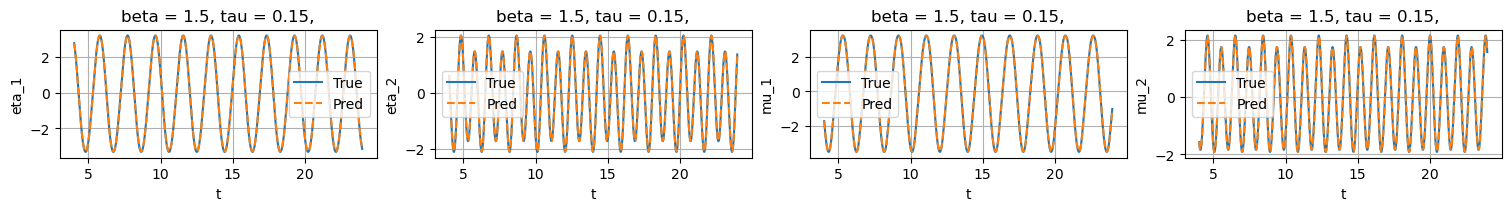

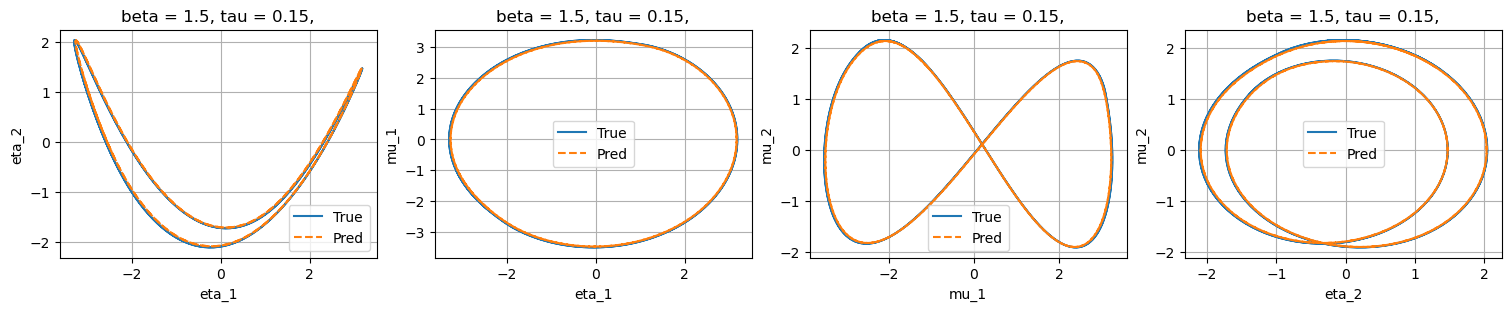

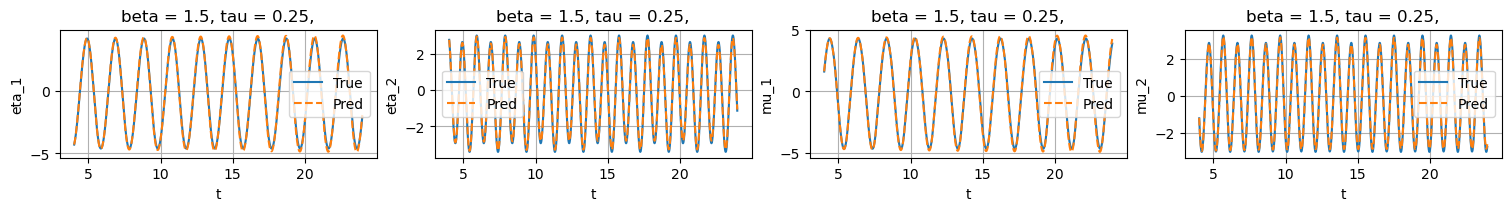

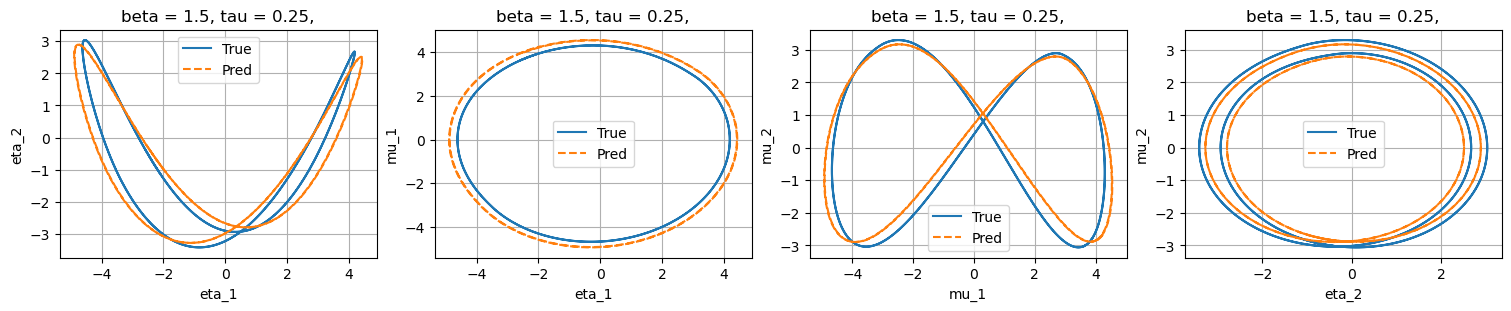

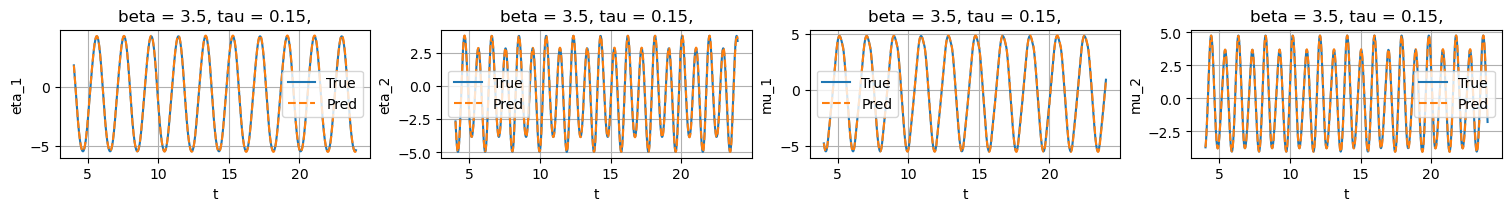

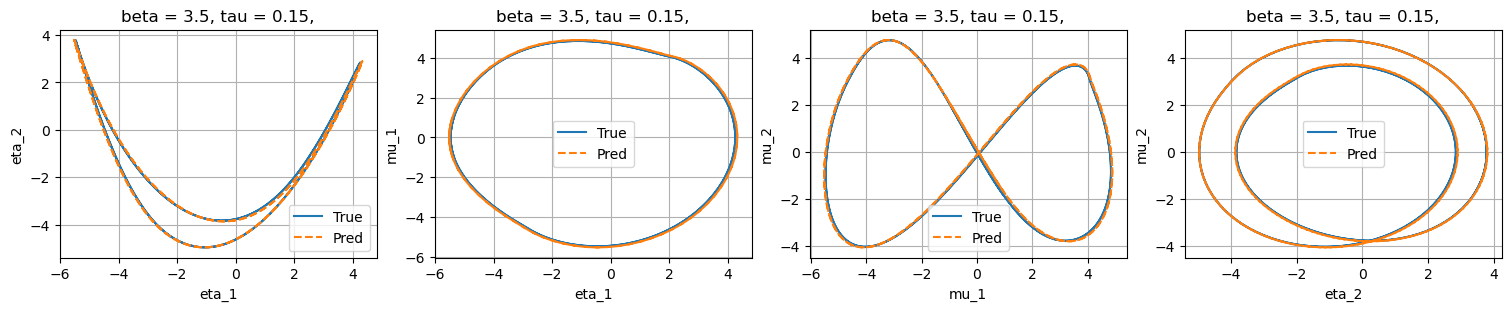

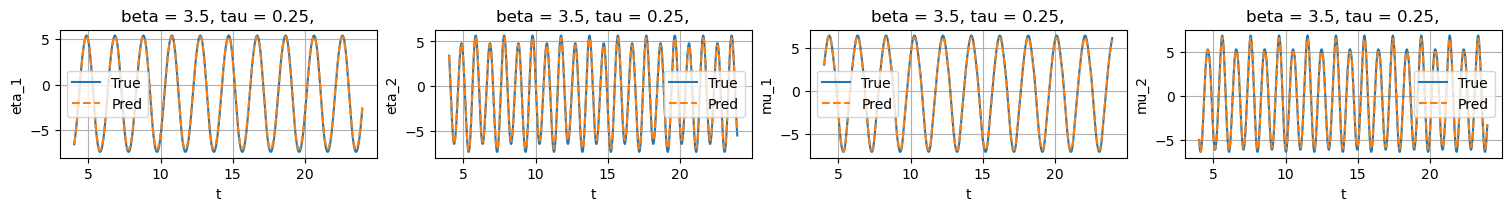

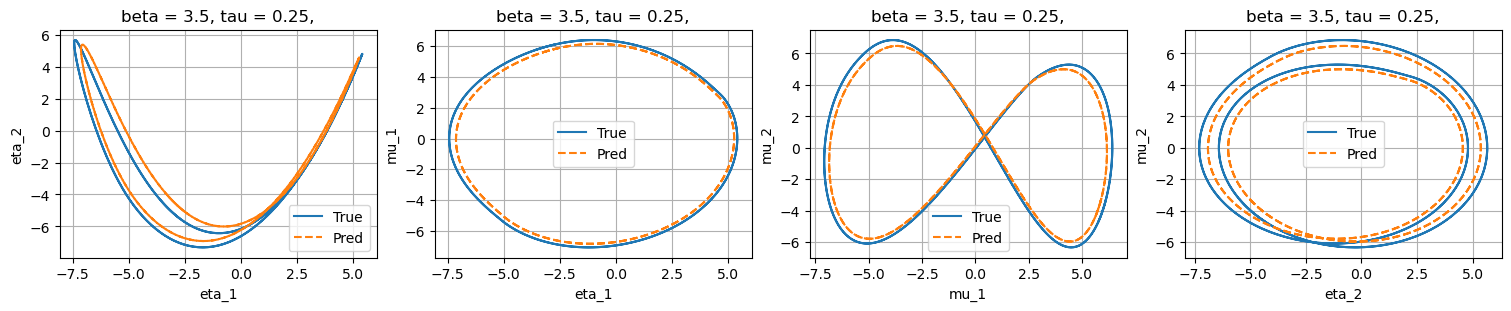

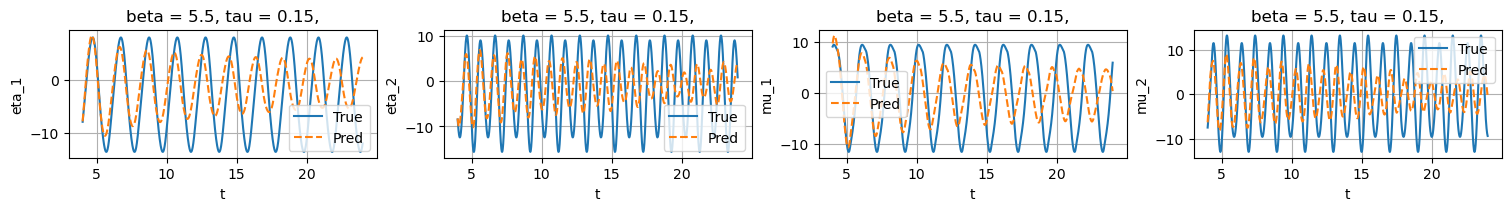

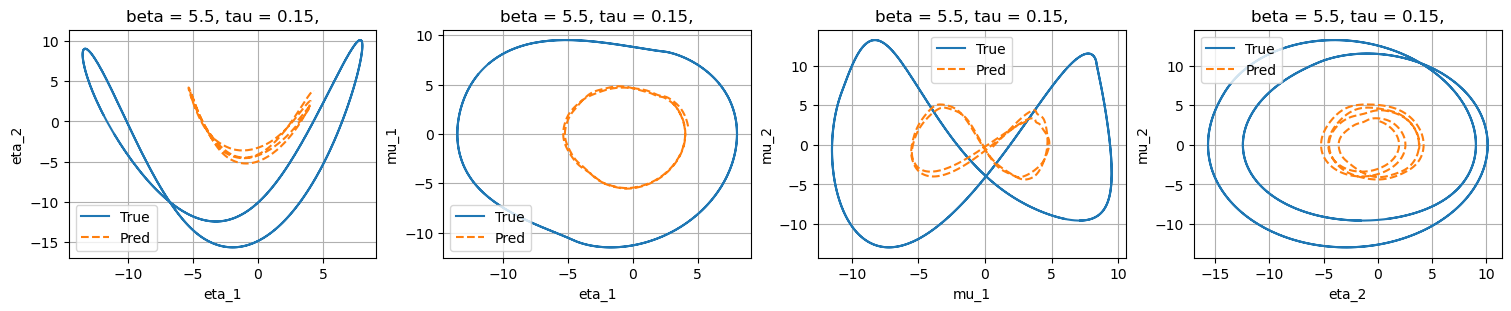

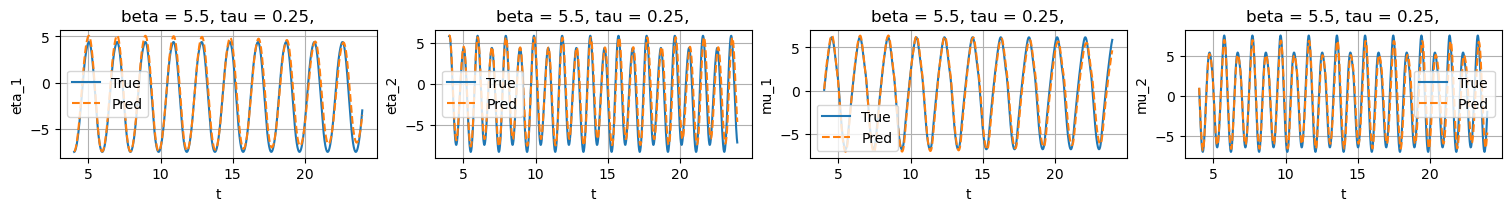

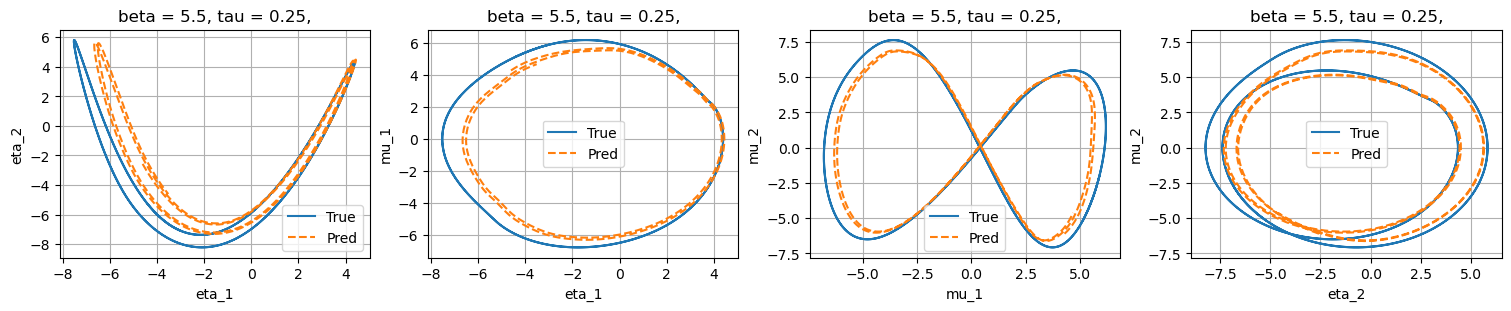

In [8]:
sim_time = 300
loop_times = [20]
beta_list = [1.5,3.5,5.5]
tau_list = [0.15,0.25]
plt_idx = [eOutputVar.eta_1,eOutputVar.eta_2,eOutputVar.mu_1,eOutputVar.mu_2]
plt_idx_pairs = [[eOutputVar.eta_1,eOutputVar.eta_2],
                 [eOutputVar.eta_1,eOutputVar.mu_1],
                 [eOutputVar.mu_1,eOutputVar.mu_2],
                 [eOutputVar.eta_2,eOutputVar.mu_2]]
phase_space_steps = pp.get_steps(4,network_dt)

error_measure = errors.rel_L2
p_list = pp.make_param_mesh([beta_list,tau_list])

for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p_sim["tau"]
    for loop_name in data.keys():
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]
        regime_str = f"beta = {p_list[p_idx][eParam.beta]}, tau = {p_list[p_idx][eParam.tau]},"

        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_lines(data[loop_name]["t"],data[loop_name]["y"][:,k],y_pred[:,k],
                       title=regime_str,
                       xlabel='t',
                       ylabel=k.name,
                       linestyle=['-','--'],
                       legend=['True','Pred'])
            
        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx_pairs):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_phase_space(data[loop_name]["y"][-phase_space_steps:],
                             y_pred[-phase_space_steps:],
                             idx_pair=k,
                             title=regime_str,
                             linestyle=['-','--'],
                             legend=['True','Pred'])
            plt.xlabel(k[0].name)
            plt.ylabel(k[1].name)

        print('Regime:',regime_str,'Error:', error_measure(data[loop_name]["y"],y_pred))

## Statistics

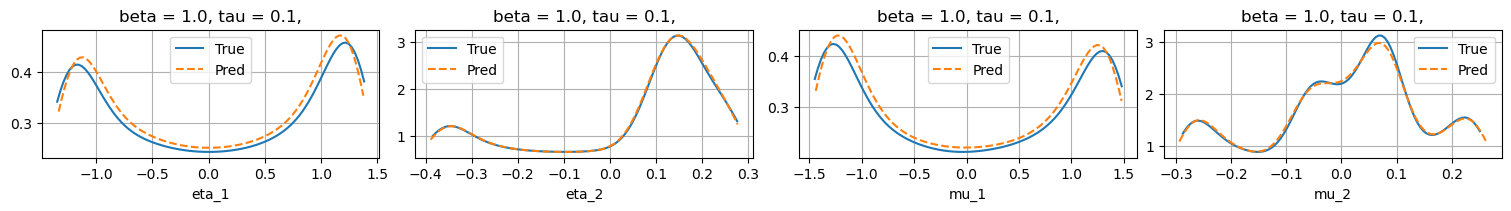

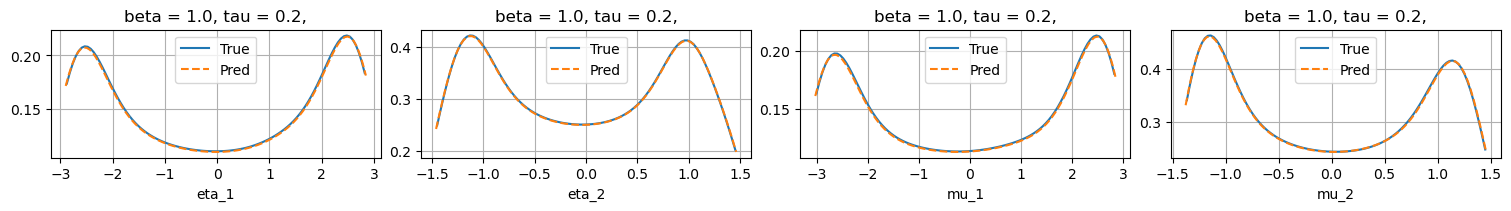

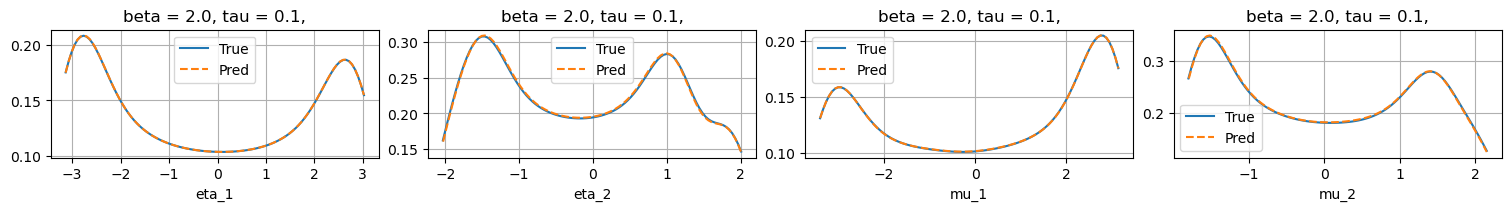

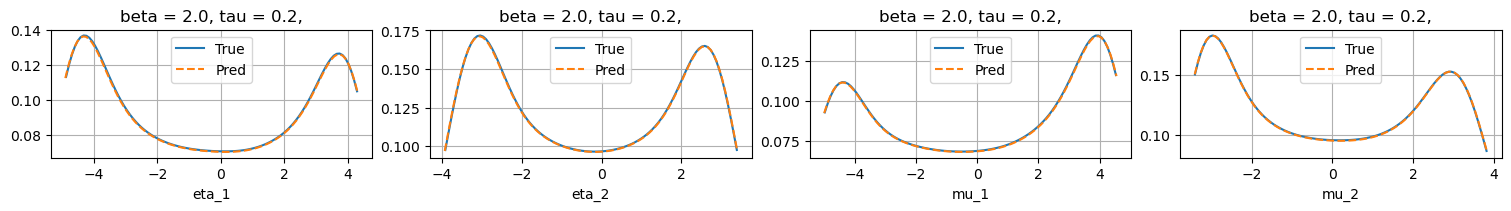

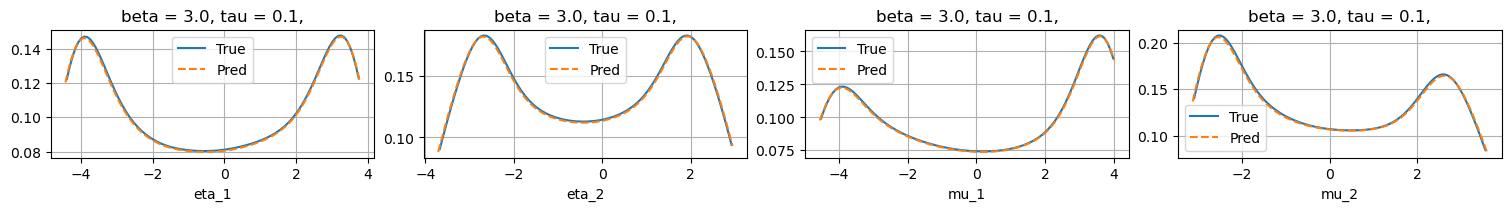

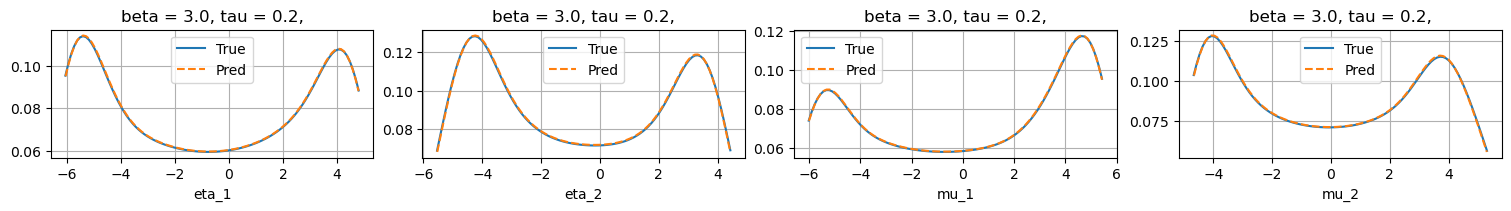

In [5]:
sim_time = 300
loop_times = [20]

beta_list = [1.5,3.5,5.5]
tau_list = [0.15,0.25]
p_list = pp.make_param_mesh([beta_list,tau_list])

plt_idx = [eOutputVar.eta_1,eOutputVar.eta_2,eOutputVar.mu_1,eOutputVar.mu_2]

for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p_sim["tau"]
    for loop_name in data.keys():
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]
        regime_str = f"beta = {p_list[p_idx][eParam.beta]}, tau = {p_list[p_idx][eParam.tau]},"

        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_statistics(data[loop_name]["y"][:,k],y_pred[:,k],
                                title=regime_str,
                                xlabel=k.name,
                                ylabel='PDF'
                                linestyle=['-','--'],
                                legend=['True','Pred'])

## Bifurcation diagram

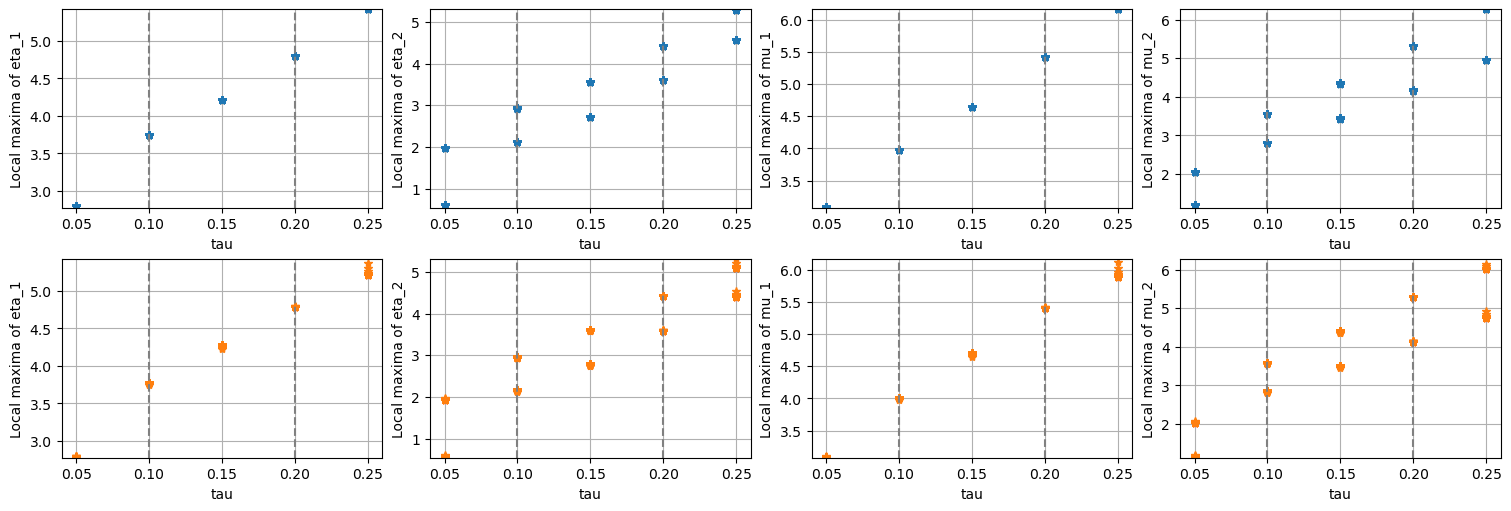

In [16]:
sim_time = 300
loop_times = [100]

beta_list = [3.0]
tau_list = np.arange(0.05,0.3,0.05)

if len(beta_list) > 1 and len(tau_list) == 1:
    vary_param = 'beta'
elif len(beta_list) == 1 and len(tau_list) > 1:
    vary_param = 'tau'
else:
    raise ValueError("For this plot one parameter needs to be varying and the other fixed.")
p_list = pp.make_param_mesh([beta_list,tau_list])

vary_param_train = list(set(INIT_p_list[train_idx_list,eParam[vary_param]]))

plt_idx = [eOutputVar.eta_1,eOutputVar.eta_2,eOutputVar.mu_1,eOutputVar.mu_2]

fig, ax = plt.subplots(nrows=2, 
                        ncols=len(plt_idx), 
                        figsize=(15,5), 
                        constrained_layout=True)

# track minimum and maximum values of the peaks 
pks_min = np.inf*np.ones((len(p_list),len(plt_idx)))   
pks_max = -np.inf*np.ones((len(p_list),len(plt_idx)))   

for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)
    
    loop_name = list(data.keys())[0]

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p_sim["tau"]
    
    _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                N_t=len(data[loop_name]["u"]), 
                                                P_washout=data[loop_name]["p_washout"],  
                                                P=data[loop_name]["p"])
    y_pred = y_pred[1:]

    for j, k in enumerate(plt_idx):
        plt.sca(ax[0,j])
        pks_true = vis.plot_bifurcation_diagram(p_sim[vary_param], data[loop_name]["y"][:,k], 
                                        color='tab:blue', 
                                        marker='*', 
                                        linestyle='None')
        min_pks_true = np.min(pks_true)
        max_pks_true = np.max(pks_true)

        plt.sca(ax[1,j])
        pks_pred = vis.plot_bifurcation_diagram(p_sim[vary_param], y_pred[:,k],
                                        color='tab:orange', 
                                        marker='*', 
                                        linestyle='None')
        min_pks_pred = np.min(pks_pred)
        max_pks_pred = np.max(pks_pred)

        pks_min[p_idx,j] = min(pks_min[p_idx,j], min(min_pks_true,min_pks_pred))
        pks_max[p_idx,j] = max(pks_max[p_idx,j], max(max_pks_true,max_pks_pred))

for j, k in enumerate(plt_idx):
    for i in range(ax.shape[0]):
        ylims = [np.min(pks_min[:,j]),np.max(pks_max[:,j])]
        ax[i,j].set_ylim(ylims)
        ax[i,j].set_xlabel(vary_param)
        ax[i,j].set_ylabel(f"Local maxima of {k.name}")
        ax[i,j].vlines(vary_param_train, ymin=ylims[0], ymax=ylims[1], color = "grey", linestyles='dashed')
        ax[i,j].grid()

## Hopf bifurcation curve

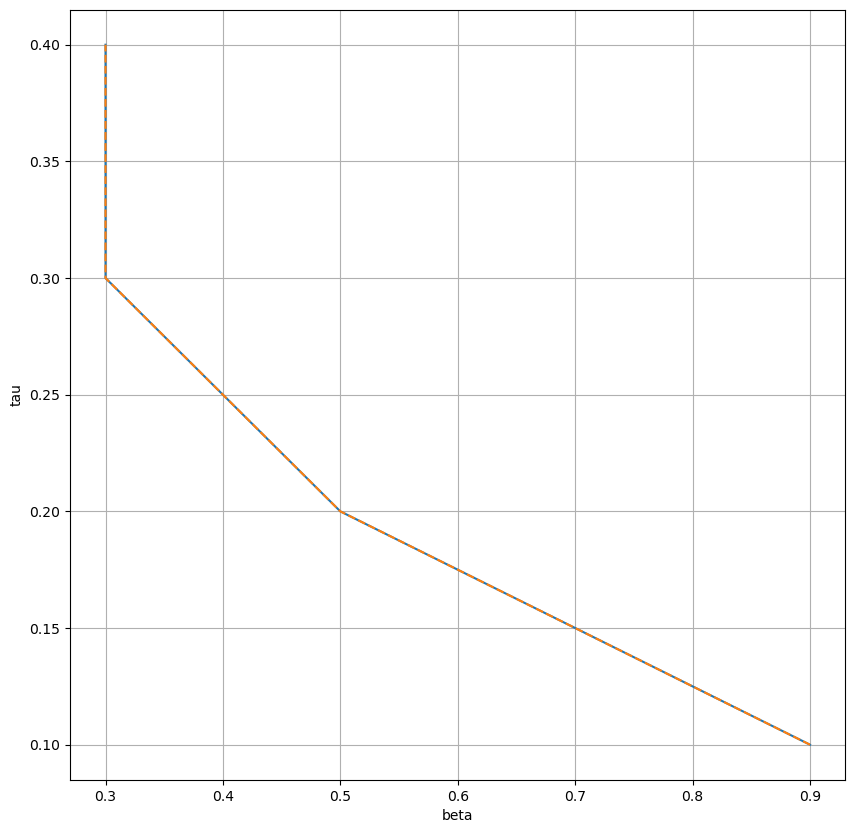

In [6]:
sim_time = 300
loop_times = [100]

beta_list = np.arange(0.2,2.5,0.1)
tau_list = np.arange(0.1,0.4,0.1)

def acoustic_energy(y, N_g):
    return 1/4*np.mean(np.sum(y[:,:2*N_g]**2, axis = 1))

def energy_decreased(y, N_g, percent_threshold = 5):
    half_steps = int(np.round(len(y)/2))
    e1 = acoustic_energy(y[:half_steps],N_g)
    e2 = acoustic_energy(y[half_steps:],N_g)
    return e1-e2 > (percent_threshold/100)*e1

percent_threshold = 5
p_energy_decreased = partial(energy_decreased, N_g=N_g, percent_threshold=percent_threshold)
bifn_point_true = np.zeros(len(tau_list))
bifn_point_pred = np.zeros(len(tau_list))

for tau_idx, tau in enumerate(tau_list):
    for beta_idx, beta in enumerate(beta_list): 
        p_sim = {'beta':beta, 'tau':tau}
        y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                    sim_time=sim_time,sim_dt=sim_dt,
                                    data_dir=data_dir)

        data = pp.create_dataset(y_sim,t_sim,p_sim,
                            network_dt=network_dt,
                            transient_time=transient_time,
                            washout_time=washout_time,
                            loop_times=loop_times,
                            input_vars=input_vars,
                            output_vars=output_vars,
                            param_vars=param_vars,
                            N_g=N_g,
                            u_f_order=u_f_order)
        
        loop_name = list(data.keys())[0]

        if hasattr(my_ESN,"tau"):
            my_ESN.tau = p_sim["tau"]
        
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]

        if p_energy_decreased(data[loop_name]["y"]):
            bifn_point_true[tau_idx] = beta

        if p_energy_decreased(y_pred):
            bifn_point_pred[tau_idx] = beta

        if not p_energy_decreased(data[loop_name]["y"]) and not p_energy_decreased(y_pred):
            break
        
plt.figure(figsize=(5,5))
vis.plot_reverse_lines(bifn_point_true,bifn_point_pred,y=tau_list,
                       linestyle=['-','--'],
                       xlabel='beta',
                       ylabel='tau')

## Sensitivity

In [9]:
N = 100
X_pred, Y_pred = my_ESN.closed_loop_with_washout(U_washout = U_washout_train[0], N_t = N, P_washout=P_washout_train[0], P = P_train[0])
dJdp_dir = my_ESN.direct_sensitivity(X_pred, Y_pred, N, N_g)
dJdp_adj = my_ESN.adjoint_sensitivity(X_pred, Y_pred, N, N_g)
dJdp_num = my_ESN.finite_difference_sensitivity(X_pred, Y_pred, P_train[0], N, N_g)
print(dJdp_dir)
print(dJdp_adj)
print(dJdp_num)

[4.59592608]
[4.59592608]
[4.59591688]


In [11]:
x0_washout = np.zeros(my_ESN.N_reservoir)
X_tau = my_ESN.open_loop(x0=x0_washout, U=U_washout_train[0], P=P_washout_train[0])
my_ESN.tau = p_list[0,1]

P = np.vstack((P_washout_train[0][-my_ESN.N_tau - 1 :, :], P_train[0]))

N = 100
X_pred, Y_pred = my_ESN.closed_loop(X_tau[-my_ESN.N_tau - 1 :, :], N, P)

dJdp_dir = my_ESN.direct_sensitivity(X_pred, Y_pred, N, X_tau)
dJdp_adj = my_ESN.adjoint_sensitivity(X_pred, Y_pred, N, X_tau)
dJdp_num = my_ESN.finite_difference_sensitivity(X_pred, Y_pred, X_tau, P, N)

print(dJdp_dir)
print(dJdp_adj)
print(dJdp_num)

0.1
0.1
0.1
0.1
[0.10728283 0.4759871 ]
[0.10728283 0.4759871 ]
[0.10728283 0.47667372]


In [ ]:
# j = np.arange(1,N_g+1,1)
# plt.figure(figsize = (12,4))
# plt.subplot(1,2,1)
# plt.plot(my_ESN.W_out[u_f_idx,N_g:])
# plt.subplot(1,2,2)
# plt.plot(my_ESN.W_out[u_f_idx,N_g:]/np.sin(j*np.pi*0.2))

# CHECK FOR BUGS IN THIS, the optimal ones seem rotated?
u_f_tau = np.arange(-10,10,0.1)

# beta_list = np.arange(0.3,1.0,0.1)
beta_list = np.arange(1.0,4.0,1.0)
# beta_list = np.arange(5.0,10.0,1.0)

# beta_list = np.arange(0.5,9.5,0.5)

q_dot_true = np.zeros((len(beta_list),len(u_f_tau)))
for beta_idx, beta in enumerate(beta_list):
    my_rijke = Rijke(N_g=N_g,N_c=10,c_1=0.1,c_2=0.06,beta=beta,x_f=0.2,tau=tau,
                    heat_law="kings_poly",damping="modal")
    for u_f_tau_idx, u_f_tau_t in enumerate(u_f_tau):
        q_dot_true[beta_idx,u_f_tau_idx] = my_rijke.kings_poly(u_f_tau_t)

q_dot = np.zeros((len(beta_list),len(u_f_tau)))
for beta_idx, beta in enumerate(beta_list):
    if my_ESN.input_weights_mode == "sparse_grouped_rijke":
        for order in range(u_f_order):
            u_f_idx = np.where(my_ESN.W_in[:,-my_ESN.N_param_dim-(u_f_order-order)].toarray() != 0)[0]
            w_in_u_f = my_ESN.W_in[u_f_idx,-my_ESN.N_param_dim-(u_f_order-order)].toarray()*(u_f_tau**(order+1))
            w_in_beta = my_ESN.W_in[u_f_idx,-1].toarray()*((beta - my_ESN.norm_p[0]) / my_ESN.norm_p[1])
            
            q_dot[beta_idx] = q_dot[beta_idx] + np.dot(my_ESN.W_out[u_f_idx,N_g], np.tanh(w_in_u_f+w_in_beta))

    elif my_ESN.input_weights_mode == "sparse_grouped_rijke_dense":
        u_f_idx = np.where(my_ESN.W_in[:,-my_ESN.N_param_dim].toarray() != 0)[0]
        w_in_beta = my_ESN.W_in[u_f_idx,-1].toarray()*((beta - my_ESN.norm_p[0]) / my_ESN.norm_p[1])

        w_in_u_f = 0
        for order in range(u_f_order):
            w_in_u_f = w_in_u_f + my_ESN.W_in[u_f_idx,-my_ESN.N_param_dim-(u_f_order-order)].toarray()*(u_f_tau**(order+1))

        q_dot[beta_idx] = np.dot(my_ESN.W_out[u_f_idx,N_g], np.tanh(w_in_u_f+w_in_beta))

    q_dot[beta_idx] = -(my_ESN.leak_factor)*q_dot[beta_idx]/(2*0.01*np.sin(np.pi*0.2))

color = plt.cm.tab20(np.linspace(0,1,len(beta_list)))
plt.figure(figsize=(10,10))
for beta_idx in range(len(beta_list)):
    plt.plot(u_f_tau, q_dot_true[beta_idx], color = color[beta_idx])

    plt.xlabel("u_f(t-tau)")
    plt.ylabel("q_dot")
    plt.legend([f"beta = {beta}" for beta in beta_list])

for beta_idx in range(len(beta_list)):
    plt.plot(u_f_tau, q_dot[beta_idx],'--', color = color[beta_idx])
plt.xlim([-0.2,0.2])
plt.ylim([-0.1,0.1])


In [ ]:
from scipy.optimize import fmin_bfgs
j = np.arange(1, N_g + 1)
modes = np.cos(j * np.pi *0.2)
modes = np.hstack((modes, np.zeros(N_g)))

for p in np.arange(0.3,1.0,0.1):
    def f(u_star): 
        # find u_f(t-tau) = u_f(t)
        u_f = np.dot(modes, u_star)
        u_augmented = np.hstack((u_star, u_f))

        # augment with the parameter
        p_norm = (p - my_ESN.parameter_normalization_mean) / my_ESN.parameter_normalization_var
        u_augmented = np.hstack((u_augmented, p_norm))

        # step
        x_tilde = np.tanh(my_ESN.W_in.dot(u_augmented))

        # output
        next_u_star = np.dot(x_tilde, my_ESN.W_out)

        error = np.linalg.norm(u_star-next_u_star)

        return error

    u0 = 0.3*np.ones(2*N_g)
    opt_u = fmin_bfgs(f, u0)
    print(opt_u)

In [ ]:
# my_ESN.train(U_washout_train, U_train, Y_train, tikhonov = 1e-3, P_washout=P_washout_train, P_train=P_train,
#               train_idx_list=[0,1,2,3,4], sample_weights=None)

WW1 = my_ESN.output_weights.copy()
# my_ESN.train(U_washout_train, U_train, Y_train, tikhonov = 1e-3, P_washout=P_washout_train, P_train=P_train,
#               train_idx_list=[0,1,2,3,4,5,6,7,8], sample_weights=None)
WW2 = my_ESN.output_weights.copy()
for i in range(8):
    plt.figure()
    plt.stem(WW1[:,i])
    # plt.plot(WW2[:,i])
    # plt.vlines(np.arange(1,10,1)*133, -1, 1, color = "black")
    plt.title(f"q_{i}")

In [23]:
for i in range(9):
    print(f"q_{i}",np.dot(my_ESN.output_weights[i*134:(i+1)*134,7],my_ESN.input_weights.toarray()[i*134:(i+1)*134,i]))

q_0 0.0007131264336963416
q_1 0.00011222108664506636
q_2 -8.481289808846913e-05
q_3 -0.12101947215777359
q_4 -0.00021849681650260716
q_5 -0.0019300112858795793
q_6 -0.0015111391052109692
q_7 -0.027743507057141244
q_8 0.8005050271241614


In [64]:
for i in range(9):
    print(f"q_{i}",np.dot(my_ESN.output_weights[i*1:(i+1)*1,7],my_ESN.input_weights.toarray()[i*1:(i+1)*1,i]))

q_0 -0.0
q_1 -0.0
q_2 -0.0
q_3 -0.09310368821352982
q_4 -0.0
q_5 -0.0
q_6 -0.0
q_7 0.9477916810639275
q_8 0.002259251874066727


In [121]:
# #--------prediction for a new parameter--------------------------------------------------------------------
par = np.arange(0.3,9.0,0.2)     # new parameter
N_washout_test = 500
N_test = 50000

local_maxx=[None]*len(par)
print('prediction started')
for ind_par in range(len(par)):
    U_init = np.zeros(dim)
    U_init[0] = 1.0
    U_washout_test = np.tile(U_init, (N_washout_test,1))
    P_test = par[ind_par]*np.ones((N_test,1))
    P_washout_test = par[ind_par]*np.ones((N_washout_test,1))
    _, Y_pred_data = my_ESN.closed_loop_with_washout(U_washout = U_washout_test, N_t = N_test-1, P_washout=P_washout_test, P = P_test)
    pred_data = Y_pred_data[20000:,0]

    aa = []
    aa_idx = []
    for ind_pred_data in range(len(pred_data)-2):
            
        if pred_data[ind_pred_data+2]-pred_data[ind_pred_data+1] < 0 and pred_data[ind_pred_data+1]-pred_data[ind_pred_data] > 0:
            aa = np.append(aa, pred_data[ind_pred_data+1])
            aa_idx = np.append(aa_idx, ind_pred_data)
            
    if pred_data[-2]-pred_data[-3] < 10**-3:
        aa = np.append(aa,pred_data[-2])
        aa_idx = np.append(aa_idx, ind_pred_data)
                
    local_maxx[ind_par] = aa

    #plt.figure(figsize=(15,4))
    #plt.plot(pred_data, color = 'tab:orange')
    #plt.plot(aa_idx,aa,'ro')
    #plt.title(f"beta = {par[ind_par]}")
    #plt.xlabel("time step")
    #plt.ylabel("q_0")

prediction started


In [15]:
def run_true_grad(my_rijke, t_bar, y_bar, data_dt, dt):
    # direct problem
    #dir0 = np.zeros(2*my_rijke.N_dim+2)
    #dir = odeint(my_rijke.direct_ode,dir0,t_bar,args=(t_bar,1/data_dt,y_bar),tfirst= True)
    #dJ_dp_dir = 1/t_bar[-1]*dir[-1,-2]
    dJ_dp_dir = 0
    
    # adjoint problem
    adjT = np.zeros(my_rijke.N_dim+2)
    adj = odeint(my_rijke.adjoint_ode,adjT,np.flip(t_bar),args =(t_bar,1/data_dt,y_bar),tfirst= True)
    dJ_dp_adj  = 1/t_bar[-1]*adj[-1,-2:]
    
    # plt.figure()
    # plt.plot(t_bar[1:],1/t_bar[1:]*adj[1:,-2])
    # plt.xlabel("t")
    # plt.title("dJ/dbeta")
    # plt.figure()
    # plt.plot(t_bar[1:],1/t_bar[1:]*adj[1:,-1])
    # plt.title("dJ/dtau")
    # dJ_dp_adj = 0
    
    # Calculate numerically
    # Find perturbed solutions (in beta)
    dJ_dp_num = np.zeros((2,))

    J = 1/4*np.mean(np.sum(y_bar[1:,0:2*my_rijke.N_g]**2, axis = 1))
    
    h = 1e-5 # perturbation on the parameter
    # left solution with beta = beta-h
    my_rijke_beta_left = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta-h,x_f=my_rijke.x_f,tau=my_rijke.tau,
                     heat_law="kings_poly",damping="modal")

    y_bar_beta_left = odeint(my_rijke_beta_left.ode,y_bar[0,:],t_bar,tfirst = True)
    J_beta_left = 1/4*np.mean(np.sum(y_bar_beta_left[1:,0:2*my_rijke_beta_left.N_g]**2, axis = 1))
        
    # right solution with beta = beta+h
    my_rijke_beta_right = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta+h,x_f=my_rijke.x_f,tau=my_rijke.tau,
                     heat_law="kings_poly",damping="modal")
    
    y_bar_beta_right = odeint(my_rijke_beta_right.ode,y_bar[0,:],t_bar,tfirst = True)
    J_beta_right = 1/4*np.mean(np.sum(y_bar_beta_right[1:,0:2*my_rijke_beta_right.N_g]**2, axis = 1))
    dJ_dp_num[0] = (J_beta_right-J_beta_left)/(2*h)

    h_tau = 1e-2
    # left solution with tau = tau-h
    my_rijke_tau_left = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta,x_f=my_rijke.x_f,tau=my_rijke.tau-h_tau,
                     heat_law="kings_poly",damping="modal")

    y_bar_tau_left = odeint(my_rijke_tau_left.ode,y_bar[0,:],t_bar,tfirst = True)
    J_tau_left = 1/4*np.mean(np.sum(y_bar_tau_left[1:,0:2*my_rijke_tau_left.N_g]**2, axis = 1))
        
    # # right solution with tau = tau+h
    my_rijke_tau_right = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta,x_f=my_rijke.x_f,tau=my_rijke.tau+h_tau,
                     heat_law="kings_poly",damping="modal")
    
    y_bar_tau_right = odeint(my_rijke_tau_right.ode,y_bar[0,:],t_bar,tfirst = True)
    J_tau_right = 1/4*np.mean(np.sum(y_bar_tau_right[1:,0:2*my_rijke_tau_right.N_g]**2, axis = 1))
    dJdp_backward = (J-J_tau_left)/(h_tau)
    dJdp_forward = (J_tau_right-J)/(h_tau)
    dJdp_central = (J_tau_right-J_tau_left)/(2*h_tau)

    dJ_dp_num[1] = dJdp_central

    print("J = ", J)
    # print("J beta left = ",J_beta_left)
    # print("J beta right = ",J_beta_right)
    print("J tau left = ",J_tau_left)
    print("J tau right = ",J_tau_right)

    #print("dJ/dp direct = ", dJ_dp_dir)
    print("dJ/dp adjoint = ", dJ_dp_adj)
    # print("dJ/dp numerical = ", dJ_dp_num)
    print("dJdp backward = ",dJdp_backward)
    print("dJdp forward  = ",dJdp_forward)
    print("dJdp central = ",dJdp_central)

    return dJ_dp_dir,dJ_dp_adj,dJ_dp_num

def run_esn_grad(my_ESN, N, X_pred_grad, Y_pred_grad, P_grad, N_tau):
    # OBJECTIVE SQUARED L2 OF OUTPUT STATES (ACOUSTIC ENERGY)
    # calculate gradient for a timeseries, direct method
    # time averaged objective
    # q = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
    # q_prev = np.zeros((my_ESN.N_reservoir, my_ESN.N_param_dim))
    dJ_dp_dir = np.zeros(my_ESN.N_param_dim)
    # for i in np.arange(1,N):
    #     q = my_ESN.drdp(X_pred_grad[i,:]).toarray()+np.dot(my_ESN.jac(X_pred_grad[i,:]).toarray(),q_prev)
    #     q_prev = q 
    #     X_pred_aug = np.hstack((X_pred_grad[i,:], my_ESN.b_out))
    #     dJ_dr = (1/N)*1/2*np.dot(np.dot(X_pred_aug,my_ESN.W_out),my_ESN.W_out[: my_ESN.N_reservoir, :].T)
    #     #dJ_dr2 = (1/N)*2*np.einsum("r, rb, bn -> n", X_pred_aug,my_ESN.W_out,my_ESN.W_out[: my_ESN.N_reservoir, :].T)
    #     dJ_dp_dir += np.dot(dJ_dr,q)
# 
    # # calculate gradient for a timeseries, adjoint method
    # time averaged objective
    # X_pred_aug = np.hstack((X_pred_grad[N - 1, :], my_ESN.b_out))
    # v_prev = (
    #     (1 / N)
    #     * 1
    #     / 2
    #     * np.dot(
    #         np.dot(X_pred_aug, my_ESN.W_out[:,:20]), my_ESN.W_out[: my_ESN.N_reservoir, :20].T
    #     ).T
    # )
    dJ_dp_adj = np.zeros(my_ESN.N_param_dim)
    # for i in np.arange(N - 1, 0, -1):
    #     dJ_dp_adj += np.dot(my_ESN.drdp(X_pred_grad[i, :]).toarray().T, v_prev)
    #     X_pred_aug = np.hstack((X_pred_grad[i - 1, :], my_ESN.b_out))
    #     dJ_dr = (
    #         (1 / N)
    #         * 1
    #         / 2
    #         * np.dot(
    #             np.dot(X_pred_aug, my_ESN.W_out[:,:20]),
    #             my_ESN.W_out[: my_ESN.N_reservoir, :20].T,
    #         ).T
    #     )
    #     v = np.dot(my_ESN.jac(X_pred_grad[i, :]).T, v_prev) + dJ_dr
    #     v_prev = v

    # calculate gradient for a timeseries, numerical method
    # time averaged objective 
    h = 1e-5
    J = 1/4*np.mean(np.sum(Y_pred_grad[:,0:2*N_g]**2, axis = 1))
    
    dJ_dp_num = np.zeros((my_ESN.N_param_dim))
    for i in range(my_ESN.N_param_dim):
        P_left = P_grad.copy()
        P_left[:,i] -= h
        P_right = P_grad.copy()
        P_right[:,i] += h
        _, Y_left = my_ESN.closed_loop(X_pred_grad[0:N_tau+1,:], N-1, P_left)
        _, Y_right =  my_ESN.closed_loop(X_pred_grad[0:N_tau+1,:], N-1, P_right)
        J_left = 1/4*np.mean(np.sum(Y_left[:,0:2*N_g]**2, axis = 1))
        J_right = 1/4*np.mean(np.sum(Y_right[:,0:2*N_g]**2, axis = 1))
        dJ_dp_num[i] = (J_right-J_left)/(2*h)
    
    print("J ESN = ", J)
    print("J left ESN = ",J_left)
    print("J right ESN = ",J_right)

    #print("dJ/dp direct ESN = ", dJ_dp_dir)
    print("dJ/dp adjoint ESN = ", dJ_dp_adj)
    print("dJ/dp numerical ESN = ", dJ_dp_num)
    return dJ_dp_dir,dJ_dp_adj,dJ_dp_num

In [14]:
def run_rijke_esn_grad(my_ESN, N, X_pred_grad, Y_pred_grad, P_grad, X_tau, N_tau):
    XX = np.vstack((X_tau[-N_tau-1:-1,:],X_pred_grad))
    # OBJECTIVE SQUARED L2 OF OUTPUT STATES (ACOUSTIC ENERGY)
    # calculate gradient for a timeseries, direct method
    # time averaged objective
    q = np.zeros((N+1, my_ESN.N_reservoir, my_ESN.N_param_dim+1))
    dJ_dp_dir = np.zeros(my_ESN.N_param_dim+1)
    # # # i = 1,..,N
    # for i in np.arange(1,N+1):
    #     dr_dbeta = my_ESN.drdp(X_pred_grad[i,:],X_pred_grad[i-1,:]).toarray()

    #     # get tau sensitivity via finite difference
    #     XX_aug_left = np.hstack((XX[i,:], my_ESN.b_out))
    #     XX_aug = np.hstack((XX[i-1,:], my_ESN.b_out))
    #     eta_tau_left = np.dot(XX_aug_left, my_ESN.W_out)[0 : my_ESN.N_g]
    #     eta_tau = np.dot(XX_aug, my_ESN.W_out)[0 : my_ESN.N_g]

    #     u_f_tau_left = Rijke.toVelocity(
    #         N_g=my_ESN.N_g, eta=eta_tau_left, x=np.array([my_ESN.x_f])
    #     )
    #     u_f_tau = Rijke.toVelocity(
    #         N_g=my_ESN.N_g, eta=eta_tau, x=np.array([my_ESN.x_f])
    #     )
        
    #     du_f_tau_dtau = (u_f_tau-u_f_tau_left)/my_ESN.dt

    #     drdu_f_tau = my_ESN.drdu_f_tau(X_pred_grad[i,:],X_pred_grad[i-1,:],u_f_tau)

    #     dr_dtau = drdu_f_tau*du_f_tau_dtau

    #     drdp = np.hstack((dr_dbeta, dr_dtau))

    #     if i <= N_tau:
    #         q[i] = (drdp
    #                 +np.dot(my_ESN.jac(X_pred_grad[i,:],X_pred_grad[i-1,:]),q[i-1]))
    #     elif i > N_tau:
    #         q[i] = (drdp
    #                 +np.dot(my_ESN.jac(X_pred_grad[i,:],X_pred_grad[i-1,:]),q[i-1])
    #                 +np.dot(my_ESN.jac_tau(X_pred_grad[i,:],X_pred_grad[i-1,:],u_f_tau),q[i-N_tau-1]))
            
        
    #     X_pred_aug = np.hstack((X_pred_grad[i,:], my_ESN.b_out))
    #     dJ_dr = (1/N)*1/2*np.dot(np.dot(X_pred_aug,my_ESN.W_out),my_ESN.W_out[: my_ESN.N_reservoir, :].T)
    #     dJ_dp_dir += np.dot(dJ_dr,q[i])

    # calculate gradient for a timeseries, adjoint method
    # time averaged objective
    v = np.zeros((N+1, my_ESN.N_reservoir))
    dJ_dp_adj = np.zeros(my_ESN.N_param_dim+1)
    
    X_pred_aug = np.hstack((X_pred_grad[N, :], my_ESN.b_out))
    v[N] = (
        (1 / N)
        * 1
        / 2
        * np.dot(
            np.dot(X_pred_aug, my_ESN.W_out), my_ESN.W_out[: my_ESN.N_reservoir, :].T
        ).T
    )
    
    for i in np.arange(N, 0, -1):
        dtanh = my_ESN.dtanh(X_pred_grad[i,:],X_pred_grad[i-1,:])[:, None]
        dr_dbeta = my_ESN.dfdp(dtanh)

        # get tau sensitivity via finite difference
        XX_aug_left = np.hstack((XX[i,:], my_ESN.b_out))
        XX_aug = np.hstack((XX[i-1,:], my_ESN.b_out))
        eta_tau_left = np.dot(XX_aug_left, my_ESN.W_out)[0 : my_ESN.N_g]
        eta_tau = np.dot(XX_aug, my_ESN.W_out)[0 : my_ESN.N_g]

        u_f_tau_left = Rijke.toVelocity(
            N_g=my_ESN.N_g, eta=eta_tau_left, x=np.array([my_ESN.x_f])
        )
        u_f_tau = Rijke.toVelocity(
            N_g=my_ESN.N_g, eta=eta_tau, x=np.array([my_ESN.x_f])
        )
        
        du_f_tau_dtau = (u_f_tau-u_f_tau_left)/my_ESN.dt

        
        drdu_f_tau = my_ESN.dfdu_f_tau(dtanh,u_f_tau)

        dr_dtau = drdu_f_tau*du_f_tau_dtau

        drdp = np.hstack((dr_dbeta, dr_dtau))
 
        dJ_dp_adj += np.dot(v[i], drdp)
        X_pred_aug = np.hstack((X_pred_grad[i-1, :], my_ESN.b_out))
        dJ_dr = (
            (1 / N)
            * 1
            / 2
            * np.dot(
                np.dot(X_pred_aug, my_ESN.W_out),
                my_ESN.W_out[: my_ESN.N_reservoir, :].T,
            ).T
        )
        if i <= N-N_tau:
            eta_tau_future = np.dot(X_pred_grad[i-1,:], my_ESN.W_out)[0 : my_ESN.N_g]
            u_f_tau_future = Rijke.toVelocity(N_g=my_ESN.N_g, eta=eta_tau_future, x=np.array([my_ESN.x_f]))
            dtanh_future = my_ESN.dtanh(X_pred_grad[i+N_tau,:],X_pred_grad[i+N_tau-1,:])
            v[i-1] = (np.dot(my_ESN.jac(dtanh).T,v[i]) 
                    +np.dot(my_ESN.jac_tau(dtanh,u_f_tau_future).T,v[i+N_tau])
                    +dJ_dr)
        else:
            v[i-1] = (np.dot(my_ESN.jac(dtanh).T,v[i]) 
                    +dJ_dr)

    # calculate gradient for a timeseries, numerical method
    # time averaged objective 
    h = 1e-5
    J = 1/4*np.mean(np.sum(Y_pred_grad[1:,0:2*my_ESN.N_g]**2, axis = 1))

    dJ_dp_num = np.zeros((my_ESN.N_param_dim+1))
    for i in range(my_ESN.N_param_dim):
        P_left = P_grad.copy()
        P_left[:,i] -= h
        P_right = P_grad.copy()
        P_right[:,i] += h
        _, Y_left = my_ESN.closed_loop(X_tau[-my_ESN.N_tau-1:,:], N, P_left)
        _, Y_right =  my_ESN.closed_loop(X_tau[-my_ESN.N_tau-1:,:], N, P_right)
        J_left = 1/4*np.mean(np.sum(Y_left[1:,0:2*my_ESN.N_g]**2, axis = 1))
        J_right = 1/4*np.mean(np.sum(Y_right[1:,0:2*my_ESN.N_g]**2, axis = 1))
        dJ_dp_num[i] = (J_right-J_left)/(2*h)

    orig_tau = my_ESN.tau
    h_tau = my_ESN.dt
    my_ESN.tau = orig_tau-h_tau
    _, Y_tau_left = my_ESN.closed_loop(X_tau[-my_ESN.N_tau-1:,:], N, P_grad)
    # my_ESN.tau = orig_tau+h_tau
    # _, Y_tau_right =  my_ESN.closed_loop(X_tau[0:my_ESN.N_tau,:], N, P_grad)
    J_tau_left = 1/4*np.mean(np.sum(Y_tau_left[1:,0:2*my_ESN.N_g]**2, axis = 1))
    # J_tau_right = 1/4*np.mean(np.sum(Y_tau_right[1:,0:2*my_ESN.N_g]**2, axis = 1))
    dJ_dp_num[-1] = (J-J_tau_left)/(h_tau)

    print("J ESN = ", J)
    # print("J left ESN = ",J_left)
    # print("J right ESN = ",J_right)
    print("J tau left ESN = ",J_tau_left)
    # print("J tau right ESN = ",J_tau_right)

    print("dJ/dp direct ESN = ", dJ_dp_dir)
    print("dJ/dp adjoint ESN = ", dJ_dp_adj)
    print("dJ/dp numerical ESN = ", dJ_dp_num)
    return dJ_dp_dir,dJ_dp_adj,dJ_dp_num

In [8]:
# Taylor test
def taylor_test(my_ESN,X_pred_grad,P_grad,N,X_tau,N_tau,dJ_dp):
    epsilon_list = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
    X, Y =  my_ESN.closed_loop(X_tau, N, P_grad)
    J_0 = 1/4*np.mean(np.sum(Y[1:,0:2*N_g]**2, axis = 1))
    taylor = np.zeros((len(epsilon_list),my_ESN.N_param_dim))
    j_1_j_0_eps = np.zeros((len(epsilon_list),my_ESN.N_param_dim))
    for epsilon_idx, epsilon in enumerate(epsilon_list):
        for i in range(my_ESN.N_param_dim):
            P_right = P_grad.copy()
            P_right[:,i] += epsilon
            X_right, Y_right =  my_ESN.closed_loop(X_tau, N, P_right)
            J_1 = 1/4*np.mean(np.sum(Y_right[1:,0:2*N_g]**2, axis = 1))
            j_1_j_0_eps[epsilon_idx, i] = (J_1-J_0)/epsilon
            taylor[epsilon_idx, i] = j_1_j_0_eps[epsilon_idx, i]-dJ_dp
            print("J_1 - J_0 = ",J_1-J_0)
            print("(J_1 - J_0)/epsilon = ",(J_1-J_0)/epsilon)
            print("(J_1 - J_0)/epsilon - dJ/dp = ",(J_1-J_0)/epsilon-dJ_dp)
            print(taylor[epsilon_idx, i])
    plt.plot(epsilon_list,np.abs(taylor[:,0]),'o-')
    # plt.plot(epsilon_list,np.abs(j_1_j_0_eps[:,0]-j_1_j_0_eps[-1,0]),'o-')
    plt.xlabel("log10(epsilon)")
    plt.ylabel("|log10((J1-J0-epsilon*dJ/dp)/epsilon)|")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Taylor test")
    plt.show()

In [16]:
my_p_list = np.arange(0.18,0.25,0.01)
# my_p_list = np.array([0.2])
n_esns = 1
dJ_dp_dir_true = np.zeros((len(my_p_list),2))
dJ_dp_adj_true = np.zeros((len(my_p_list),2))
dJ_dp_adj_true_long = np.zeros((len(my_p_list),2))
dJ_dp_num_true = np.zeros((len(my_p_list),2))
dJ_dp_dir_esn = np.zeros((n_esns,len(my_p_list),2))
dJ_dp_adj_esn = np.zeros((n_esns,len(my_p_list),2))
dJ_dp_num_esn = np.zeros((n_esns,len(my_p_list),2))
J_bar = np.zeros(len(my_p_list))
J_esn = np.zeros(len(my_p_list))

sim_dict3 = {"t_sim_len": 310,
            "data_dt": 1e-3,
            "dt": 1e-2,
            "t_transient_len": 200,
            "t_washout_len": 10,
            "t_train_len": 100,
            "t_val_len": 0,
            }
param = "tau"
x_f_grad = 0.2
my_ESN.x_f = x_f_grad
for esn_idx in range(n_esns):
    # my_ESN = RijkeESN(reservoir_size = 1200, 
    #         N_g = N_g,
    #         u_f_order = u_f_order,
    #         x_f = 0.2,
    #         tau = 0.2,
    #         dt = 0.01,
    #         parameter_dimension = 1, 
    #         reservoir_connectivity = 3, 
    #         spectral_radius = 0.1,    
    #         input_scaling = 0.1130046,                             
    #         u_f_scaling= 1.39332475,
    #         leak_factor = 0.20882743,
    #         parameter_normalization=[np.array([-2.12880738,]),np.array([1.38678768])],
    #         input_bias = np.array([]),
    #         output_bias = np.array([]),
    #         input_normalization = scale, 
    #         input_seeds=[1,2,3],
    #         r2_mode=False,
    #         input_weights_mode="sparse_grouped_rijke_dense",
    #         input_only_mode=True,
    #         verbose=False)
    # my_ESN.train(U_washout_train, U_train, Y_train, tikhonov = 1e-3, P_washout=P_washout_train, P_train=P_train,
    #           train_idx_list=np.arange(len(p_list)), sample_weights=None)
    for p_idx, my_p in enumerate(my_p_list):
        if param == "beta":
            beta_grad = my_p
            print("Beta:", beta_grad)
            tau_grad = 0.2
            my_ESN.tau = tau_grad
        elif param == "tau":
            tau_grad = my_p
            print("Tau:", tau_grad)
            my_ESN.tau = tau_grad
            beta_grad= 2.5
        print(my_ESN.tau)
        print(my_ESN.N_tau)
        beta_name = f'{beta_grad:.2f}'
        beta_name = beta_name.replace(".","_")
        tau_name = f'{tau_grad:.2f}'
        tau_name = tau_name.replace(".","_")
        data_path = f"data_new/rijke_kings_poly_N_g_4_beta_{beta_name}_tau_{tau_name}.h5"
        if not Path(data_path).exists():
            data_path = None
        data_path = None
        my_rijke = Rijke(N_g=N_g,N_c=10,c_1=0.1,c_2=0.06,beta=beta_grad,x_f=x_f_grad,tau=tau_grad,
                heat_law="kings_poly",damping="modal")
        y_sim, U_sim, t_sim = run_rijke_sim(beta_grad,tau_grad,N_g,
                                            sim_dict3["t_sim_len"],sim_dict3["data_dt"], data_path = data_path, u_f_order=u_f_order, x_f = x_f_grad)

        U_washout, U_grad, Y_grad, t_grad, _, _, _, _ = create_dataset(U_sim,t_sim,
                    sim_dict3["dt"],
                    sim_dict3["t_transient_len"],
                    sim_dict3["t_washout_len"],
                    sim_dict3["t_train_len"],
                    sim_dict3["t_val_len"],
                    u_f_order=u_f_order)
        
        J_bar[p_idx] = 1/4*np.mean(np.sum(Y_grad[:,0:2*my_rijke.N_g]**2, axis = 1))

        print("J_true = ", J_bar[p_idx])
        if data_path is None:
            N_transient = int(sim_dict3["t_transient_len"]/sim_dict3["data_dt"])
            y_bar = y_sim[N_transient:,:]
            t_bar = t_sim[N_transient:]

            N_washout = int(sim_dict3["t_washout_len"]/sim_dict3["data_dt"])
            y_bar = y_bar[N_washout:,:]
            t_bar = t_bar[N_washout:]-t_bar[N_washout]

            N_train = int(sim_dict3["t_train_len"]/sim_dict3["data_dt"])
            y_bar = y_bar[:N_train,:]
            t_bar = t_bar[:N_train]
            dJ_dp_dir_true[p_idx],dJ_dp_adj_true[p_idx],dJ_dp_num_true[p_idx] = run_true_grad(my_rijke, t_bar, y_bar, sim_dict3["data_dt"], sim_dict3["dt"])
        else:
            data_dict = pp.read_h5(data_path)
            dJ_dp_adj_true_long[p_idx] = [data_dict["dJ_dbeta"],data_dict["dJ_dtau"]]
            # print("dJ/dp true = ", dJ_dp_adj_true[p_idx])
            print("dJ/dp true long= ", dJ_dp_adj_true_long[p_idx])

        N = int(np.round(sim_dict3["t_train_len"]/sim_dict3["dt"]))
        P_grad = beta_grad*np.ones((N,1))
        P_washout = beta_grad*np.ones((len(U_washout),1))
        N_tau = int(tau_grad/sim_dict3["dt"])
        # Wash-out phase to get rid of the effects of reservoir states initialised as zero
        # initialise the reservoir states before washout
        x0_washout = np.zeros(my_ESN.N_reservoir)

        # let the ESN run in open-loop for the wash-out
        # get the initial reservoir to start the actual open/closed-loop,
        # which is the last reservoir state

        # X_tau = my_ESN.open_loop(x0=x0_washout, U=U_washout, P=P_washout)[
        #     -my_ESN.N_tau - 1 :, :
        # ]

        X_tau = my_ESN.open_loop(x0=x0_washout, U=U_washout, P=P_washout)
        P_grad = np.vstack((P_washout[-my_ESN.N_tau - 1 :, :], P_grad))
        X_pred_grad, Y_pred_grad = my_ESN.closed_loop(X_tau[-my_ESN.N_tau - 1 :, :], N_t=N, P=P_grad)
        J_esn[p_idx] = 1/4*np.mean(np.sum(Y_pred_grad[1:,0:2*my_rijke.N_g]**2, axis = 1))
        # _,dJ_dp_adj_esn[esn_idx][p_idx],dJ_dp_num_esn[esn_idx][p_idx] = run_rijke_esn_grad(my_ESN, N, X_pred_grad, Y_pred_grad, P_grad, 
        #                                                                                    X_tau = X_tau, N_tau = N_tau)  
        dJ_dp_adj_esn[esn_idx][p_idx] = my_ESN.adjoint_sensitivity(X_pred_grad, Y_pred_grad, N, X_tau)
        dJ_dp_num_esn[esn_idx][p_idx] = my_ESN.finite_difference_sensitivity(X_pred_grad, Y_pred_grad, X_tau, P_grad, N)
        print("dJ/dp adjoint ESN = ", dJ_dp_adj_esn[esn_idx][p_idx])
        print("dJ/dp numerical ESN = ", dJ_dp_num_esn[esn_idx][p_idx])

Tau: 0.18
0.18
18
J_true =  9.983958802368212
J =  9.984054990977718
J tau left =  9.311492983457004
J tau right =  10.688235316777742
dJ/dp adjoint =  [ 4.66266827 68.85892011]
dJdp backward =  67.2562007520714
dJdp forward  =  70.41803258000243
dJdp central =  68.8371166660369
dJ/dp adjoint ESN =  [ 4.66800508 66.47601401]
dJ/dp numerical ESN =  [ 4.66800508 66.46291709]
Tau: 0.19
0.19
19
J_true =  10.717015475168113
J =  10.716945294056229
J tau left =  10.014992660395965
J tau right =  11.454294080084203
dJ/dp adjoint =  [ 5.0567501  72.02264148]
dJdp backward =  70.19526336602641
dJdp forward  =  73.73487860279741
dJdp central =  71.96507098441191
dJ/dp adjoint ESN =  [ 5.06647766 68.9369442 ]
dJ/dp numerical ESN =  [ 5.06647765 68.90275877]
Tau: 0.2
0.2
20
J_true =  11.510560137983013
J =  11.510553010094632
J tau left =  10.776391893767396
J tau right =  12.262891853803412
dJ/dp adjoint =  [ 5.37823772 74.46322066]
dJdp backward =  73.41611163272361
dJdp forward  =  75.233884370

KeyboardInterrupt: 

J_1 - J_0 =  5.831047361872879
(J_1 - J_0)/epsilon =  5.831047361872879
(J_1 - J_0)/epsilon - dJ/dp =  1.4223010959922462
1.4223010959922462
J_1 - J_0 =  0.45599436143338057
(J_1 - J_0)/epsilon =  4.559943614333806
(J_1 - J_0)/epsilon - dJ/dp =  0.1511973484531728
0.1511973484531728
J_1 - J_0 =  0.0442382984547649
(J_1 - J_0)/epsilon =  4.42382984547649
(J_1 - J_0)/epsilon - dJ/dp =  0.015083579595857266
0.015083579595857266
J_1 - J_0 =  0.00441025212903412
(J_1 - J_0)/epsilon =  4.41025212903412
(J_1 - J_0)/epsilon - dJ/dp =  0.001505863153487219
0.001505863153487219
J_1 - J_0 =  0.0004408896824497077
(J_1 - J_0)/epsilon =  4.408896824497077
(J_1 - J_0)/epsilon - dJ/dp =  0.00015055861644430735
0.00015055861644430735
J_1 - J_0 =  4.408761320906507e-05
(J_1 - J_0)/epsilon =  4.408761320906507
(J_1 - J_0)/epsilon - dJ/dp =  1.5055025873955685e-05
1.5055025873955685e-05
J_1 - J_0 =  4.408747775741517e-06
(J_1 - J_0)/epsilon =  4.408747775741517
(J_1 - J_0)/epsilon - dJ/dp =  1.5098608843

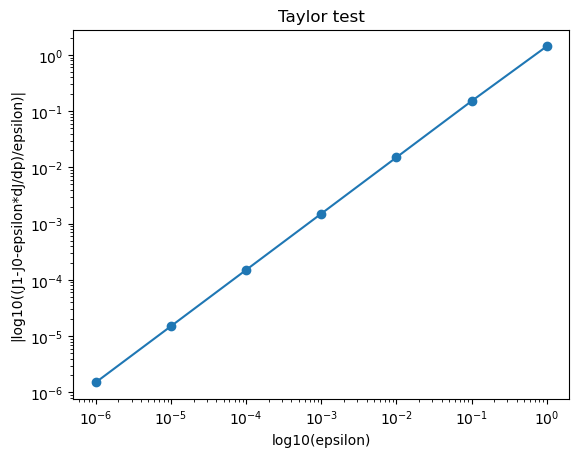

In [72]:
taylor_test(my_ESN,X_pred_grad,P_grad,N,X_tau,N_tau,dJ_dp_adj_esn[0][0])

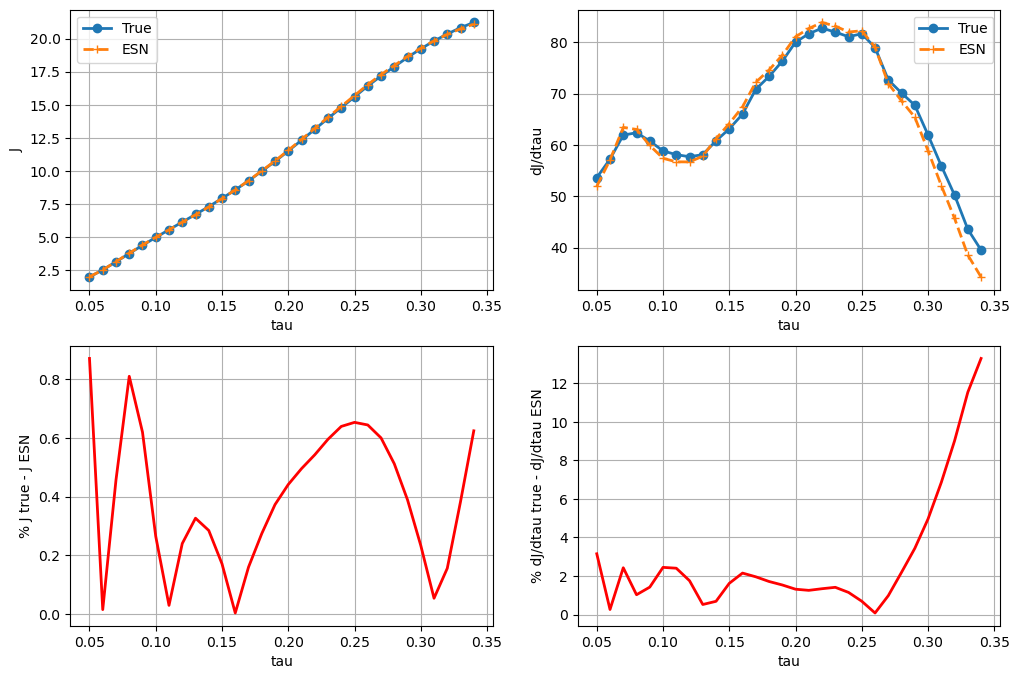

In [26]:
plt.figure(figsize = (12,8))
plt.subplot(2,2,1)
plt.plot(my_p_list, J_bar, linewidth = 2, marker = 'o')
plt.plot(my_p_list, J_esn,'--', linewidth = 2, marker = '+')
plt.xlabel(param)
plt.ylabel("J")
plt.legend(["True","ESN"])
plt.grid()

dJdp_true_numm = np.gradient(J_bar, my_p_list[1]-my_p_list[0])
dJdp_esn_numm = np.gradient(J_esn, my_p_list[1]-my_p_list[0])
plt.subplot(2,2,2)
plt.plot(my_p_list, dJdp_true_numm, linewidth = 2, marker = 'o')
plt.plot(my_p_list, dJdp_esn_numm,'--', linewidth = 2, marker = '+')
plt.xlabel(param)
plt.ylabel("dJ/d"+param)
plt.legend(["True","ESN"])
plt.grid()

plt.subplot(2,2,3)
plt.plot(my_p_list, 100*np.abs(J_bar-J_esn)/J_bar, linewidth = 2, color = "red")
plt.xlabel(param)
plt.ylabel("% J true - J ESN")
plt.grid()

plt.subplot(2,2,4)
plt.plot(my_p_list, 100*np.abs(dJdp_true_numm-dJdp_esn_numm)/dJdp_true_numm, linewidth = 2, color = "red")
plt.xlabel(param)
plt.ylabel("% dJ/dtau true - dJ/dtau ESN")
plt.grid()

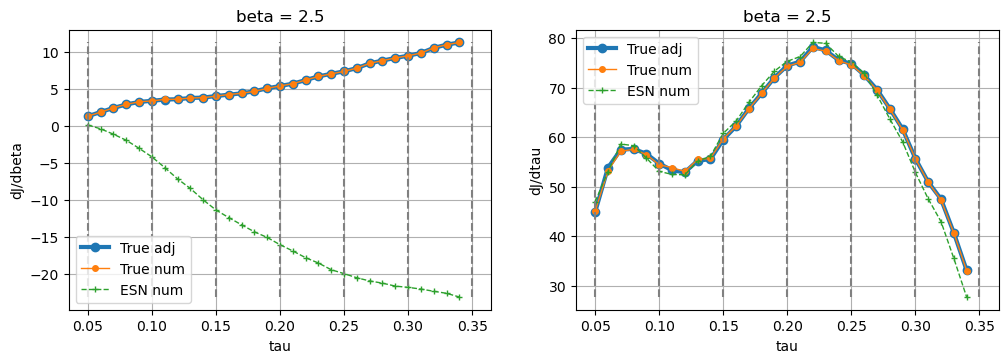

In [35]:
dJ_dp_num_esn_mean = np.mean(dJ_dp_num_esn, axis = 0)
dJ_dp_num_esn_std = np.std(dJ_dp_num_esn, axis = 0)
dJ_dp_adj_esn_mean = np.mean(dJ_dp_adj_esn, axis = 0)
dJ_dp_adj_esn_std = np.std(dJ_dp_adj_esn, axis = 0)
plt.figure(figsize = (12,8))
param = "tau"
for i in range(2):
    plt.subplot(2,2,i+1)
    plt.plot(my_p_list,dJ_dp_adj_true[:,i],linestyle = '-',marker = 'o', markersize = 6, linewidth = 3)
    plt.plot(my_p_list,dJ_dp_num_true[:,i],linestyle = '-',marker = 'o', markersize = 4, linewidth = 1)
    # plt.plot(my_p_list,dJ_dp_adj_esn_mean[:,i],linestyle = '--',marker = '+', markersize = 6, linewidth = 3)
    plt.plot(my_p_list,dJ_dp_num_esn_mean[:,i],linestyle = '--',marker = '+', markersize = 4, linewidth = 1)
    # plt.fill_between(my_p_list, dJ_dp_num_esn_mean[:,i]-dJ_dp_num_esn_std[:,i], dJ_dp_num_esn_mean[:,i]+dJ_dp_num_esn_std[:,i],
    #     alpha=0.2, facecolor='tab:orange',antialiased=True)
    ymin = np.min([np.min(dJ_dp_adj_true[:,i]),np.min(dJ_dp_num_true[:,i]),np.min(dJ_dp_num_esn_mean[:,i])])
    ymax = np.max([np.max(dJ_dp_adj_true[:,i]),np.max(dJ_dp_num_true[:,i]),np.max(dJ_dp_num_esn_mean[:,i])])
    if param == "beta":
        plt.vlines(np.array(list(set(p_list[:,0]))), 
                   ymin=ymin, ymax=ymax, 
                   color = "grey", linestyles='dashed')
        plt.xlabel("beta")
        plt.title(f"tau = {tau_grad}")
    elif param == "tau":
        plt.vlines(np.array(list(set(p_list[:,1]))),
                    ymin=ymin, ymax=ymax, 
                    color = "grey", linestyles='dashed')
        plt.xlabel("tau")
        plt.title(f"beta = {beta_grad}")

    if i == 0:
        plt.ylabel("dJ/dbeta")
    elif i == 1:
        plt.ylabel("dJ/dtau")
    plt.legend(["True adj","True num","ESN num"])
    # plt.ylim([0,10])
    # plt.xlim([0,2])
    plt.grid()

    # plt.subplot(2,2,i+3)
    # rel_err = 100*np.abs(dJ_dp_adj_true[:,i]-dJ_dp_adj_esn_mean[:,i])/dJ_dp_adj_true[:,i]
    # plt.plot(my_p_list,rel_err,linestyle = '-', markersize = 6, linewidth = 2, color = "red")
    # if param == "beta":
    #     plt.vlines(np.array(list(set(p_list[:,0]))), 
    #                ymin=np.min(rel_err), ymax=np.max(rel_err), 
    #                color = "grey", linestyles='dashed')
    #     plt.xlabel("beta")
    # elif param == "tau":
    #     plt.vlines(np.array(list(set(p_list[:,1]))),
    #                 ymin=np.min(rel_err), ymax=np.max(rel_err), 
    #                 color = "grey", linestyles='dashed')
    #     plt.xlabel("tau")
    # if i == 0:
    #     plt.ylabel("dJ/dbeta % rel error")
    # elif i == 1:
    #     plt.ylabel("dJ/dtau % rel error")
    # plt.grid()

In [9]:
# Calculate jacobian of the reservoir states analytically
x_tau = X_pred_grad[0,:]
x_0 = X_pred_grad[N_tau,:]
x_1 = X_pred_grad[N_tau+1,:]
p_0 = P_grad[0]
# now compare this jacobian to the numerical one
def closed_loop_step(x_tau, x_0, p_0):
    x_0_augmented = np.hstack((x_0, my_ESN.b_out))

    y_tau = np.dot(x_tau, my_ESN.W_out)
    eta_tau = y_tau[0 : my_ESN.N_g]
    velocity_f_tau = Rijke.toVelocity(
        N_g= my_ESN.N_g, eta=eta_tau, x=np.array([my_ESN.x_f])
    )
    y_0 = np.dot(x_0_augmented, my_ESN.W_out)
    y_0 = np.hstack((y_0, velocity_f_tau, velocity_f_tau**2))
    
    x_1 = my_ESN.step(x_0, y_0, p_0)
    return x_1

def closed_loop_step_f(velocity_f_tau, x_0, p_0):
    x_0_augmented = np.hstack((x_0, my_ESN.b_out))
    y_0 = np.dot(x_0_augmented, my_ESN.W_out)
    y_0 = np.hstack((y_0, velocity_f_tau, velocity_f_tau**2))
    
    x_1 = my_ESN.step(x_0, y_0, p_0)
    return x_1
h = 1e-5

# THE BUG IS TO DO WITH THE ALPHA! because alpha = 1.0, the jacs match perfectly
# if alpha not 1.0, then 1-tanh^2(x(i)) no longer equal to 1-x(i+1)^2
my_jac = my_ESN.jac(x_1, x_0)
my_jac_num = np.zeros((my_ESN.N_reservoir,my_ESN.N_reservoir))
for i in range(my_ESN.N_reservoir):
    x_0_left = x_0.copy()
    x_0_left[i] -= h
    x_0_right = x_0.copy()
    x_0_right[i] += h
    x_1_left = closed_loop_step(x_tau,x_0_left,p_0)
    x_1_right = closed_loop_step(x_tau,x_0_right,p_0)
    for j in range(my_ESN.N_reservoir):
        my_jac_num[j,i] = (x_1_right[j]-x_1_left[j])/(2*h)      
print("Difference of analytical vs numerical Jacobian:",np.where(np.abs(my_jac_num-my_jac) > 1e-8))

my_drdp = my_ESN.drdp(x_1, x_0)
p_0_left = p_0-h
p_0_right = p_0+h
x_1_left = closed_loop_step(x_tau,x_0,p_0_left)
x_1_right = closed_loop_step(x_tau,x_0,p_0_right)
my_drdp_num = (x_1_right-x_1_left)/(2*h)
print("Difference of analytical vs numerical dr/dp:",np.where(np.abs(my_drdp_num[:,None]-my_drdp.toarray()) > 1e-8))

y_tau = np.dot(x_tau, my_ESN.W_out)
eta_tau = y_tau[0 : my_ESN.N_g]
u_f_tau_0 = Rijke.toVelocity(
    N_g= my_ESN.N_g, eta=eta_tau, x=np.array([my_ESN.x_f])
)
my_drdu_f_tau = my_ESN.drdu_f_tau(x_1, x_0, u_f_tau_0)
u_f_tau_0_left = u_f_tau_0-h
u_f_tau_0_right = u_f_tau_0+h
x_1_left = closed_loop_step_f(u_f_tau_0_left,x_0,p_0)
x_1_right = closed_loop_step_f(u_f_tau_0_right,x_0,p_0)
my_drdu_f_tau_num = (x_1_right-x_1_left)/(2*h)
print("Difference of analytical vs numerical dr/du_f_tau:",np.where(np.abs(my_drdu_f_tau_num[:,None]-my_drdu_f_tau) > 1e-8))

my_jac_tau = my_ESN.jac_tau(x_1, x_0, u_f_tau_0)
my_jac_tau_num = np.zeros((my_ESN.N_reservoir,my_ESN.N_reservoir))
for i in range(my_ESN.N_reservoir):
    x_tau_left = x_tau.copy()
    x_tau_left[i] -= h
    x_tau_right = x_tau.copy()
    x_tau_right[i] += h
    x_1_left = closed_loop_step(x_tau_left,x_0,p_0)
    x_1_right = closed_loop_step(x_tau_right,x_0,p_0)
    for j in range(my_ESN.N_reservoir):
        my_jac_tau_num[j,i] = (x_1_right[j]-x_1_left[j])/(2*h)      
print("Difference of analytical vs numerical Jacobian tau:",np.where(np.abs(my_jac_tau_num-my_jac_tau) > 1e-8))

Difference of analytical vs numerical Jacobian: (array([], dtype=int64), array([], dtype=int64))
Difference of analytical vs numerical dr/dp: (array([], dtype=int64), array([], dtype=int64))
Difference of analytical vs numerical dr/du_f_tau: (array([], dtype=int64), array([], dtype=int64))
Difference of analytical vs numerical Jacobian tau: (array([], dtype=int64), array([], dtype=int64))


In [10]:
my_drdu_f_tau.shape

(1200, 1)